# Artificial neural network

In [10]:
#imports
from visualization.neural_network_plots import plot_loss, plot_accuracy, plot_multiple_loss_curves, plot_multiple_accuracy_curves, plot_multiple_f_scores
from preprocessing.preprocessing_one_hot_encoding import get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split, get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split, get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_undersampled,get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_oversampled ,get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split_undersampled, get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split_oversampled

from sklearn.metrics import fbeta_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import WeightedRandomSampler

import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

Create device for pytorch

In [4]:
use_mps = True
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Torch mps activated


In [5]:
class CustomBrfssDataset(data_utils.Dataset):
    def __init__(self, dataset, dataset_target):
        self.dataset = torch.tensor(np.array(dataset)).float()
        self.target = torch.tensor(np.array(dataset_target)).float()

    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, idx):
            return self.dataset[idx], self.target[idx]

Define artifical network

In [6]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size:int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.do2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(5, output_size)

    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)
        x = F.relu(x, inplace=False)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=False)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x

Define accuracy and loss function for network analysis and plots

In [7]:
def get_accuracy(model: Net, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

def get_loss(model: Net, criterion, data_loader):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(data_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        pass

    return running_loss/len(data_loader)

def get_f_score(model: Net, data_loader):
    running_predictions = []
    running_labels = []

    model.eval()
    for i, data in enumerate(data_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        running_predictions.extend(predicted.detach().cpu().numpy().ravel())
        running_labels.extend(labels.detach().cpu().numpy().ravel())
        pass

    #print(f"Debug fix output: {running_predictions[0:5]} {running_labels[0:5]}")
    f_score = fbeta_score(y_true=running_labels, y_pred=running_predictions, beta=2, pos_label=1, average="binary")
    precision = precision_score(y_true=running_labels, y_pred=running_predictions)
    recall = recall_score(y_true=running_labels, y_pred=running_predictions)

    return f_score, precision, recall



In [8]:
def make_weights_for_balanced_classes(data, nclasses):
    count = [0] * nclasses
    for item in data:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(data)
    for idx, val in enumerate(data):
        weight[idx] = weight_per_class[val[1]]
    return weight

Training loop

In [9]:
def train_network(model: Net, criterion, optimizer, data_train_loader, data_validation_loader, n_epochs=5):
    loss_values = []
    accuracy_values = []
    loss_values_validation = []
    accuracy_values_validation = []
    f_scores = []
    f_scores_validation = []

    for epoch in range(n_epochs):

        running_loss = 0.0

        model.train()
        for i, data in enumerate(data_train_loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 batches
                print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / i:.3f}')
            pass

        loss_values.append(running_loss/len(data_train_loader))
        validation_loss = get_loss(model, criterion, data_validation_loader)
        train_accuracy = 100 * get_accuracy(model, data_train_loader)
        validation_accuracy = 100 * get_accuracy(model, data_validation_loader)
        accuracy_values.append(train_accuracy)
        accuracy_values_validation.append(validation_accuracy)
        loss_values_validation.append(validation_loss)

        print(f"Epoch {epoch} loss: {str(running_loss/len(data_train_loader))}")
        print(f"Epoch {epoch} validation loss: {validation_loss}")
        print(f'Train accuracy: {train_accuracy} %')
        print(f'Validation accuracy: {validation_accuracy} %')

        f_train, p_train, r_train = get_f_score(net, data_train_loader)
        f_validation, p_validation, r_validation = get_f_score(net, data_validation_loader)
        f_scores.append(f_train)
        f_scores_validation.append(f_validation)

        print(f"Train F2-score : {f_train}")
        print(f"Validation F2-score : {f_validation}")
        print(f"Train Precision : {p_train}")
        print(f"Validation Precision : {p_validation}")
        print(f"Train Recall : {r_train}")
        print(f"Validation Recall : {r_validation}")

    print('Finished Training')
    return loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation

### Train model without under or oversampling

In [9]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

# Custom weighted sampling required because otherwise the f2 score can be zero when all samples are from the same class, random sampling is not suitable
class_count_train = [target_train["No"].sum(),target_train["Yes"].sum()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float)
class_weights_train_all = class_weights_train[np.where(target_train.to_numpy()==1)[1]]

class_count_validation = [target_validation["No"].sum(),target_validation["Yes"].sum()]
class_weights_validation = 1./torch.tensor(class_count_validation, dtype=torch.float)
class_weights_validation_all = class_weights_validation[np.where(target_validation.to_numpy()==1)[1]]

weighted_sampler_train = WeightedRandomSampler(weights=class_weights_train_all, num_samples=target_train.shape[0], replacement=True)
weighted_sampler_validation = WeightedRandomSampler(weights=class_weights_validation_all, num_samples=target_validation.shape[0], replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_train)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_validation)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)
loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=50)

Input size: 73
Output size: 2
[1, 12800] loss: 0.580
[1, 25600] loss: 0.543
[1, 38400] loss: 0.527
[1, 51200] loss: 0.520
[1, 64000] loss: 0.512
[1, 76800] loss: 0.508
[1, 89600] loss: 0.504
[1, 102400] loss: 0.502
[1, 115200] loss: 0.499
[1, 128000] loss: 0.497
[1, 140800] loss: 0.495
[1, 153600] loss: 0.493
[1, 166400] loss: 0.492
Epoch 0 loss: 0.4912472582901969
Epoch 0 validation loss: 0.48873987543311986
Train accuracy: 75.79493374071838 %
Validation accuracy: 75.59597825700786 %
Train F2-score : 0.8517302569237096
Validation F2-score : 0.8472991898574713
Train Precision : 0.7000716411330321
Validation Precision : 0.6948100118141605
Train Recall : 0.9004997459919899
Validation Recall : 0.896486936793222
[2, 12800] loss: 0.477
[2, 25600] loss: 0.473
[2, 38400] loss: 0.472
[2, 51200] loss: 0.471
[2, 64000] loss: 0.470
[2, 76800] loss: 0.470
[2, 89600] loss: 0.469
[2, 102400] loss: 0.469
[2, 115200] loss: 0.468
[2, 128000] loss: 0.467
[2, 140800] loss: 0.467
[2, 153600] loss: 0.467
[

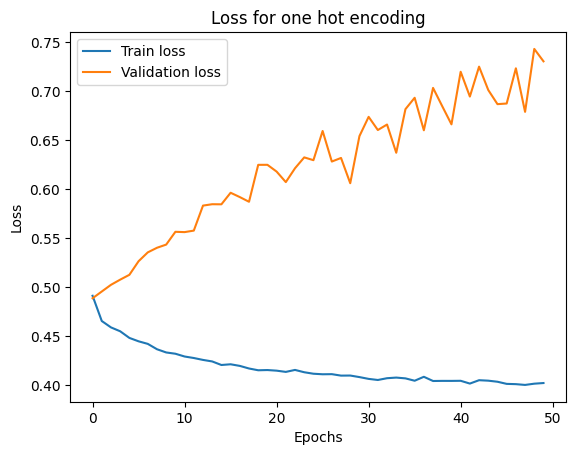

In [10]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding")

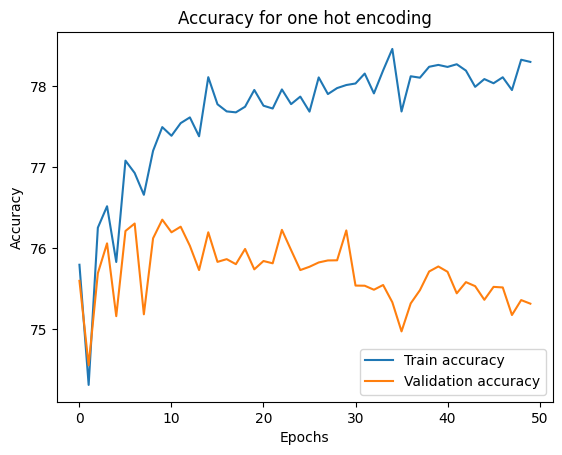

In [11]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding")

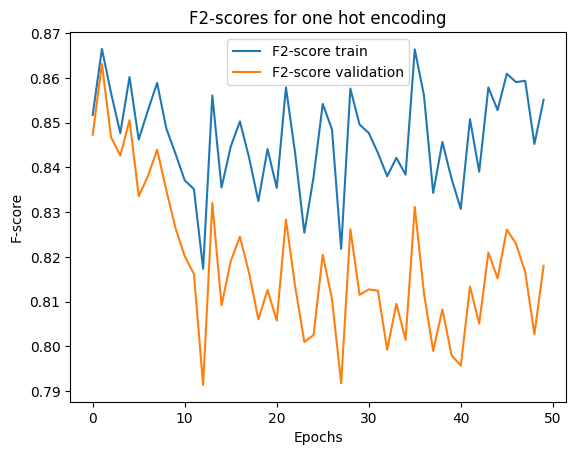

In [12]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding")

### Train model with undersampling

In [13]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split_undersampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)
loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=100)

Input size: 73
Output size: 2
[1, 12800] loss: 0.646
[1, 25600] loss: 0.619
[1, 38400] loss: 0.599
Epoch 0 loss: 0.5909266731090094
Epoch 0 validation loss: 0.8195350621234286
Train accuracy: 74.92012779552716 %
Validation accuracy: 73.23693466444026 %
Train F2-score : 0.7619966905681191
Validation F2-score : 0.5784188347764104
Train Precision : 0.7403536977491961
Validation Precision : 0.2919113368248426
Train Recall : 0.7676066120294486
Validation Recall : 0.7664953465759133
[2, 12800] loss: 0.535
[2, 25600] loss: 0.527
[2, 38400] loss: 0.523
Epoch 1 loss: 0.5218575923929553
Epoch 1 validation loss: 0.7548763953826644
Train accuracy: 74.55202111404363 %
Validation accuracy: 78.69755213699506 %
Train F2-score : 0.7018934181179708
Validation F2-score : 0.5688429961134237
Train Precision : 0.7794171892290668
Validation Precision : 0.3368284877783074
Train Recall : 0.6848636384683058
Validation Recall : 0.6871787748298375
[3, 12800] loss: 0.503
[3, 25600] loss: 0.497
[3, 38400] loss: 0.5

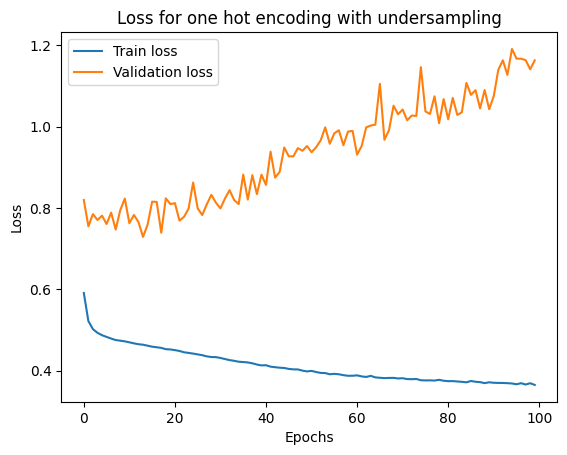

In [14]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with undersampling")

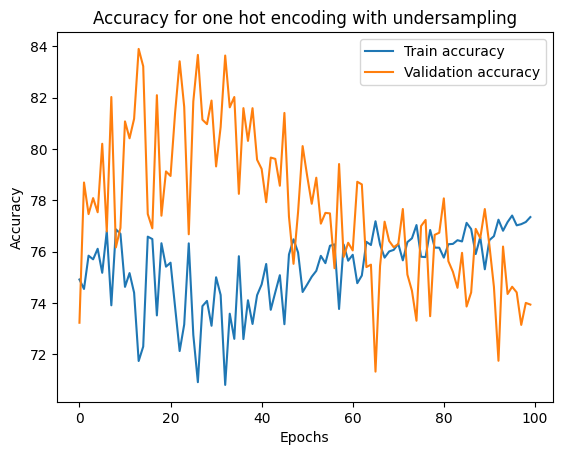

In [15]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with undersampling")

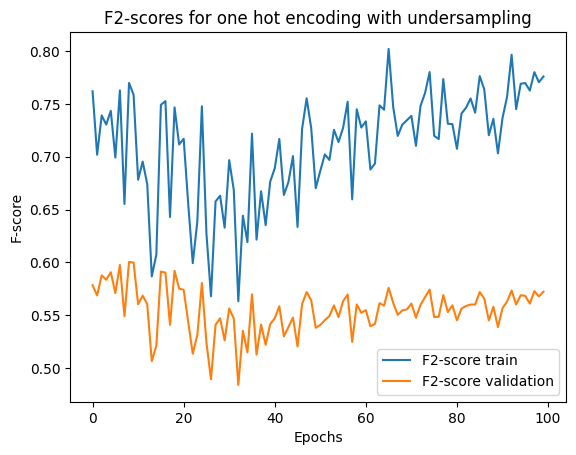

In [16]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding with undersampling")

### Train model with oversampling

In [17]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split_oversampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)
loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=25)

Input size: 73
Output size: 2
[1, 12800] loss: 0.571
[1, 25600] loss: 0.539
[1, 38400] loss: 0.522
[1, 51200] loss: 0.513
[1, 64000] loss: 0.506
[1, 76800] loss: 0.502
[1, 89600] loss: 0.499
[1, 102400] loss: 0.497
[1, 115200] loss: 0.496
[1, 128000] loss: 0.494
[1, 140800] loss: 0.493
[1, 153600] loss: 0.492
[1, 166400] loss: 0.490
[1, 179200] loss: 0.489
[1, 192000] loss: 0.488
[1, 204800] loss: 0.487
[1, 217600] loss: 0.487
[1, 230400] loss: 0.486
[1, 243200] loss: 0.486
[1, 256000] loss: 0.485
[1, 268800] loss: 0.484
[1, 281600] loss: 0.483
[1, 294400] loss: 0.483
Epoch 0 loss: 0.482832720042
Epoch 0 validation loss: 0.8117615095593712
Train accuracy: 62.305054825678106 %
Validation accuracy: 34.82431520233062 %
Train F2-score : 0.8643051300348029
Validation F2-score : 0.49090708544168543
Train Precision : 0.5708217566812425
Validation Precision : 0.16282898497701964
Train Recall : 0.9917846352310147
Validation Recall : 0.9891651618280317
[2, 12800] loss: 0.473
[2, 25600] loss: 0.4

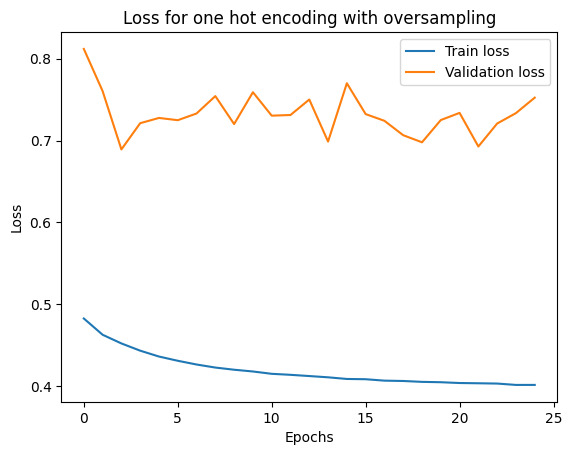

In [18]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with oversampling")

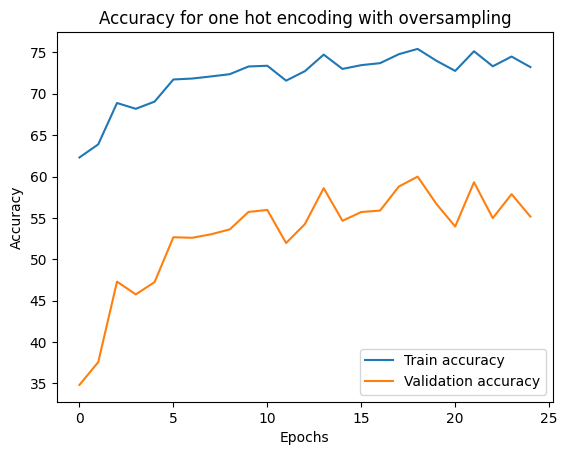

In [19]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with oversampling")

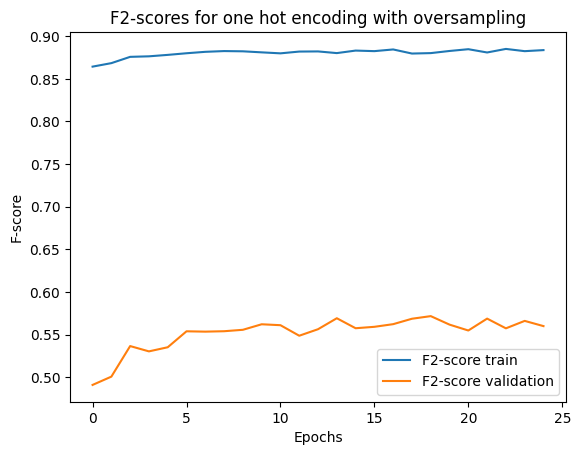

In [20]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding with oversampling")

### Train model with undersampling

In [21]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

# Custom weighted sampling required because otherwise the f2 score can be zero when all samples are from the same class, random sampling is not suitable
class_count_train = [target_train["No"].sum(),target_train["Yes"].sum()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float)
class_weights_train_all = class_weights_train[np.where(target_train.to_numpy()==1)[1]]

class_count_validation = [target_validation["No"].sum(),target_validation["Yes"].sum()]
class_weights_validation = 1./torch.tensor(class_count_validation, dtype=torch.float)
class_weights_validation_all = class_weights_validation[np.where(target_validation.to_numpy()==1)[1]]

weighted_sampler_train = WeightedRandomSampler(weights=class_weights_train_all, num_samples=target_train.shape[0], replacement=True)
weighted_sampler_validation = WeightedRandomSampler(weights=class_weights_validation_all, num_samples=target_validation.shape[0], replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_train)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_validation)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=50)



Input size: 91
Output size: 2
[1, 12800] loss: 0.545
[1, 25600] loss: 0.520
[1, 38400] loss: 0.510
[1, 51200] loss: 0.502
[1, 64000] loss: 0.498
[1, 76800] loss: 0.493
[1, 89600] loss: 0.490
[1, 102400] loss: 0.488
[1, 115200] loss: 0.486
[1, 128000] loss: 0.484
[1, 140800] loss: 0.483
[1, 153600] loss: 0.481
[1, 166400] loss: 0.480
Epoch 0 loss: 0.480014017404932
Epoch 0 validation loss: 0.4857497112994844
Train accuracy: 77.07452540827323 %
Validation accuracy: 76.96024443102284 %
Train F2-score : 0.7794239884712925
Validation F2-score : 0.7815495658057967
Train Precision : 0.7658695727622948
Validation Precision : 0.7661691542288557
Train Recall : 0.7828878902554399
Validation Recall : 0.785491640691414
[2, 12800] loss: 0.483
[2, 25600] loss: 0.479
[2, 38400] loss: 0.473
[2, 51200] loss: 0.473
[2, 64000] loss: 0.470
[2, 76800] loss: 0.469
[2, 89600] loss: 0.469
[2, 102400] loss: 0.469
[2, 115200] loss: 0.469
[2, 128000] loss: 0.469
[2, 140800] loss: 0.469
[2, 153600] loss: 0.468
[2,

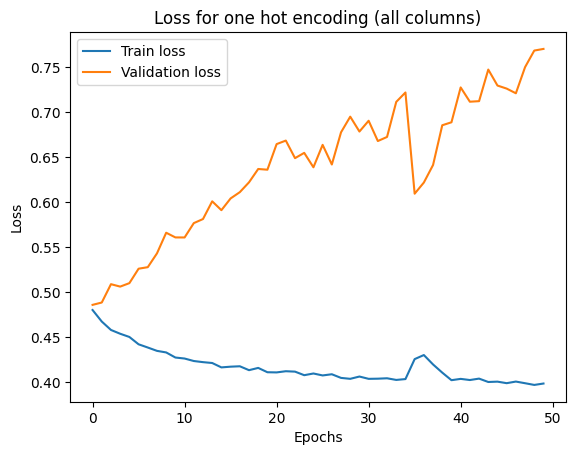

In [22]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding (all columns)")

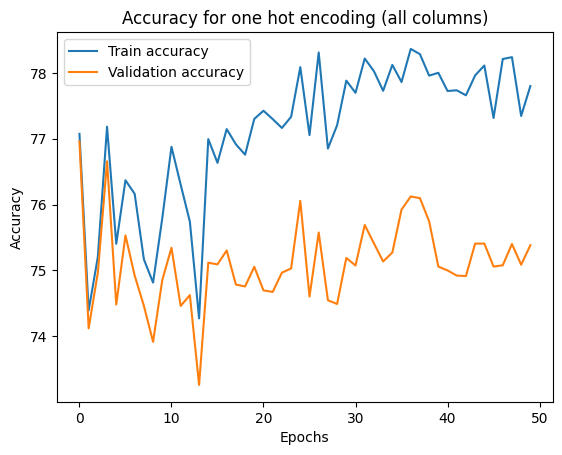

In [23]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding (all columns)")

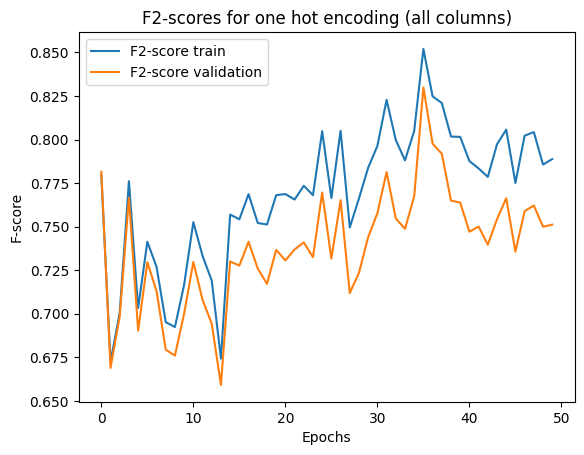

In [24]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding (all columns)")

In [25]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_undersampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=100)

Input size: 91
Output size: 2
[1, 12800] loss: 0.703
[1, 25600] loss: 0.630
[1, 38400] loss: 0.603
Epoch 0 loss: 0.5935518523821464
Epoch 0 validation loss: 0.7200180487199264
Train accuracy: 75.50585729499467 %
Validation accuracy: 71.40903115784985 %
Train F2-score : 0.789774635359467
Validation F2-score : 0.5881756208407726
Train Precision : 0.7315566017907437
Validation Precision : 0.2829396837790357
Train Recall : 0.8058063619947214
Validation Recall : 0.8053896374496458
[2, 12800] loss: 0.532
[2, 25600] loss: 0.526
[2, 38400] loss: 0.519
Epoch 1 loss: 0.5164820854304105
Epoch 1 validation loss: 0.7343222566626288
Train accuracy: 75.74200120387091 %
Validation accuracy: 67.48498951930934 %
Train F2-score : 0.8291823162231515
Validation F2-score : 0.5935977066411849
Train Precision : 0.7119115685153421
Validation Precision : 0.2640146202558545
Train Recall : 0.864796036486549
Validation Recall : 0.8628976246700931
[3, 12800] loss: 0.506
[3, 25600] loss: 0.503
[3, 38400] loss: 0.502

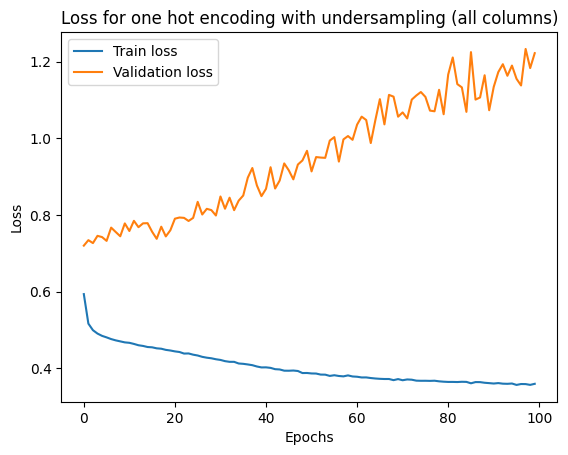

In [26]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with undersampling (all columns)")

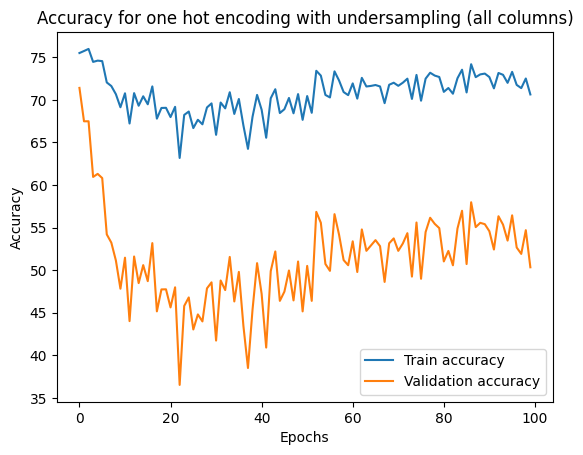

In [27]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with undersampling (all columns)")

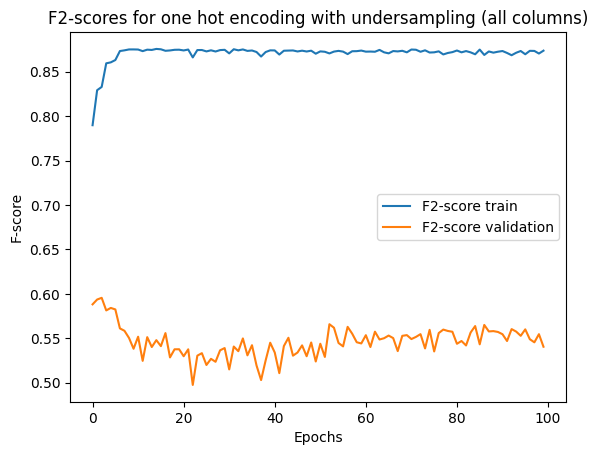

In [28]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding with undersampling (all columns)")

In [29]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_oversampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=25)

Input size: 91
Output size: 2
[1, 12800] loss: 0.802
[1, 25600] loss: 0.751
[1, 38400] loss: 0.717
[1, 51200] loss: 0.692
[1, 64000] loss: 0.675
[1, 76800] loss: 0.661
[1, 89600] loss: 0.650
[1, 102400] loss: 0.640
[1, 115200] loss: 0.633
[1, 128000] loss: 0.626
[1, 140800] loss: 0.621
[1, 153600] loss: 0.615
[1, 166400] loss: 0.610
[1, 179200] loss: 0.606
[1, 192000] loss: 0.603
[1, 204800] loss: 0.600
[1, 217600] loss: 0.596
[1, 230400] loss: 0.594
[1, 243200] loss: 0.591
[1, 256000] loss: 0.588
[1, 268800] loss: 0.585
[1, 281600] loss: 0.583
[1, 294400] loss: 0.580
Epoch 0 loss: 0.5798650990223284
Epoch 0 validation loss: 0.6791177608750083
Train accuracy: 68.14135859048783 %
Validation accuracy: 46.3441929868192 %
Train F2-score : 0.8701303284803449
Validation F2-score : 0.5310609055249795
Train Precision : 0.6148963892102015
Validation Precision : 0.18892314349072423
Train Recall : 0.9708795871948942
Validation Recall : 0.970412557299625
[2, 12800] loss: 0.526
[2, 25600] loss: 0.5

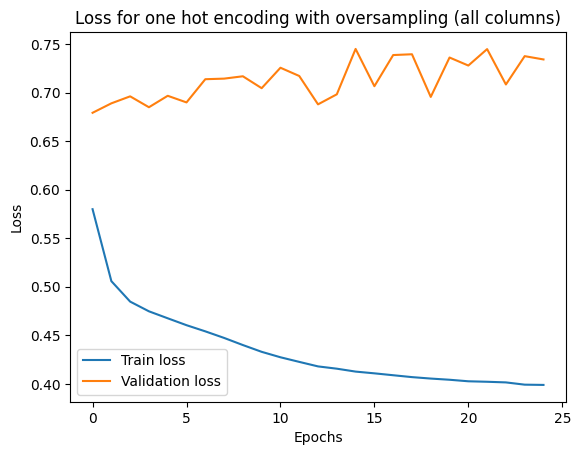

In [30]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with oversampling (all columns)")

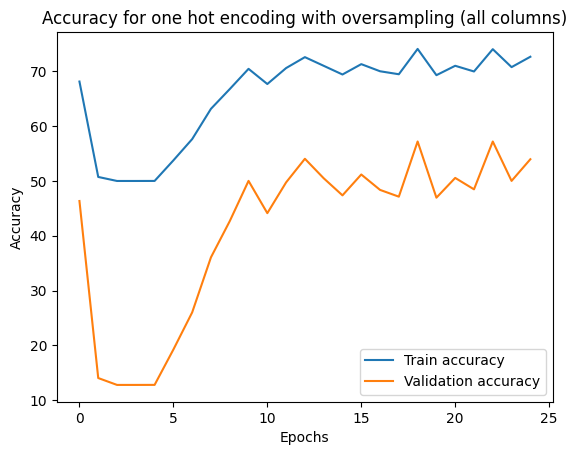

In [31]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with oversampling (all columns)")

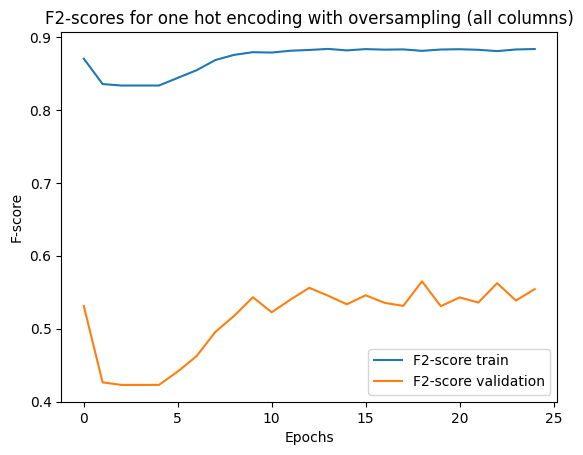

In [32]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for one hot encoding with oversampling (all columns)")

In [11]:
data_train, data_validation, data_test, target_train, target_validation, target_test = get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split(target_one_hot_encoded=True, include_test_data=True)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
test_dataset = CustomBrfssDataset(data_test, target_test)

# Custom weighted sampling required because otherwise the f2 score can be zero when all samples are from the same class, random sampling is not suitable
class_count_train = [target_train["No"].sum(),target_train["Yes"].sum()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float)
class_weights_train_all = class_weights_train[np.where(target_train.to_numpy()==1)[1]]

class_count_test = [target_test["No"].sum(),target_test["Yes"].sum()]
class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float)
class_weights_test_all = class_weights_test[np.where(target_test.to_numpy()==1)[1]]

weighted_sampler_train = WeightedRandomSampler(weights=class_weights_train_all, num_samples=target_train.shape[0], replacement=True)
weighted_sampler_test = WeightedRandomSampler(weights=class_weights_test_all, num_samples=target_test.shape[0], replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_train)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_test)

net = Net(input_size=input_size, output_size=output_size)
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)
loss_values, loss_values_test, accuracy_values, accuracy_values_test, f_scores, f_scores_test = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=test_loader, n_epochs=2)

Input size: 73
Output size: 2
[1, 12800] loss: 0.561
[1, 25600] loss: 0.529
[1, 38400] loss: 0.515
[1, 51200] loss: 0.506
[1, 64000] loss: 0.501
[1, 76800] loss: 0.498
[1, 89600] loss: 0.494
[1, 102400] loss: 0.492
[1, 115200] loss: 0.490
[1, 128000] loss: 0.489
[1, 140800] loss: 0.488
[1, 153600] loss: 0.487
[1, 166400] loss: 0.485
Epoch 0 loss: 0.4846406760992426
Epoch 0 validation loss: 0.49192919304425065
Train accuracy: 76.69082554683152 %
Validation accuracy: 76.09023891997512 %
Train F2-score : 0.8326468675482334
Validation F2-score : 0.8242131481621253
Train Precision : 0.7249545531306187
Validation Precision : 0.7229394240317776
Train Recall : 0.8647620627547635
Validation Recall : 0.8541259288228392
[2, 12800] loss: 0.466
[2, 25600] loss: 0.468
[2, 38400] loss: 0.467
[2, 51200] loss: 0.468
[2, 64000] loss: 0.469
[2, 76800] loss: 0.468
[2, 89600] loss: 0.467
[2, 102400] loss: 0.466
[2, 115200] loss: 0.466
[2, 128000] loss: 0.466
[2, 140800] loss: 0.466
[2, 153600] loss: 0.466
